# Clustering
Unsupervised machine learning. Discrete classification. 

Links: [Tutorial](https://matteucci.faculty.polimi.it/Clustering/tutorial_html/index.html) from Italy.
[sklearn](https://scikit-learn.org/stable/modules/clustering.html) index of all algorithms.
[sklearn](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html) comparison on toy datasets.

Clustering metrics: 
* single-linkage clustering (min)
* complete-linkage clustering (max)
* average-linkage clustering
* K-means minimimizes sum of squared norms of deviations from the cluster mean, where norm is usually Euclidean disatnace
* Ward uses centroids and SSE. It is similar to ANOVA in that it minimizes intra vs inter group variance. It is similar to K-means but the clusters are characterized by member points not points in space. 
* The standard algorithm is called "Lloyd." 
It recomputes every pairwise Euclidean distance on every iteration.
* The Elkan optimization uses triangle inequality between triplets
to avoid some recomputes. 
Conceptually, if point 2 was previously closer to the mean than point 1,
and the mean only moved a little, then point 2 is still closer. The squared distance to point 1 is still dominant.





In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
#np.random.seed(0)

Here are some standard data sets.

In [2]:
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

In [3]:
# Nice colors for showing clusters
COLORS = np.array(["#377eb8","#ff7f00","#4daf4a","#f781bf","#a65628","#984ea3","#999999","#e41a1c","#dede00"])

## Hierarchical clustering
### Agglomerative clustering
Bottom-up. Scales well. Works with any distance metric, even non-Euclidean ones. Can choose #clusters interactively.  

SciKit-Learn tools: 
* [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) AgglomerativeClustering. You can set the stopping criteria by #clusters or a distance threshold. You can access attributes like #clusters, #leaves, #features used, and #connected components.    
* [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.FeatureAgglomeration.html#sklearn.cluster.FeatureAgglomeration) FeatureAgglomeration can cluster features for dimensionality reduction.

In [4]:
# Simple wrapper for AgglomerativeClustering.
def make_clusters(XY, num_clusters=None):
    X = XY[0]
    Y = XY[1]
    alg = cluster.AgglomerativeClustering()
    if num_clusters is not None:
        alg = cluster.AgglomerativeClustering(num_clusters)  
        ## with no setting, it converges on 2
    alg.fit(X)
    ypred = alg.labels_
    print('#clusters',alg.n_clusters_,'cluster assignments per point',alg.labels_)
    plt.scatter(X[:, 0], X[:, 1], color=COLORS[ypred])
    plt.show()

#clusters 2 cluster assignments per point [1 1 1 0 0 0]


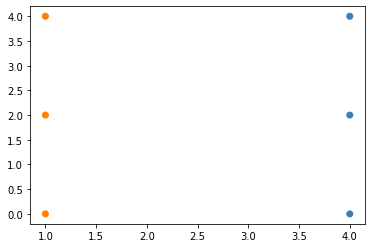

In [5]:
# This simple example demonstrates success.
X = np.array([[1, 2], [1, 4], [1, 0], [4, 2], [4, 4], [4, 0]])
Y = [0,0,0,1,1,1]
make_clusters( (X,Y) )

#clusters 2 cluster assignments per point [0 0 1 ... 0 0 0]


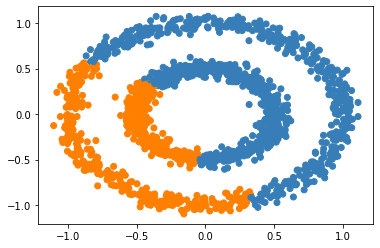

In [6]:
# This failed example demonstrates risk of using Euclidean distance.
make_clusters(noisy_circles)

#clusters 3 cluster assignments per point [2 2 2 ... 2 1 1]


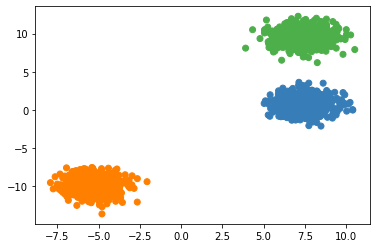

In [7]:
# This example shows success with K=2 or K=3.
make_clusters(blobs,3)  

#clusters 5 cluster assignments per point [2 3 3 ... 0 0 1]


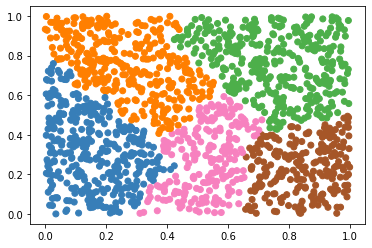

In [8]:
# When the data don't have natural clusters,
# the algorithm might partition the data into equal-size clusters.
make_clusters(no_structure,5)

## Partition clustering
### K-Means Clustering  
Easy to use. Fast. K is a parameter.
Note the means are points in space not data instances.
This makes the algorithm sensitive to outliers.
The computation can fail on singularities induced by 
cluster size 1 (zero variance) or cluster size 0.
K-means is not optimal; it finds a local optimum. 
In particular, once it merges two real clusters,
those clusters will never separate.
The algorithm is sensitive to the initial means.
It is recommended to try several reruns with different random initializers.

Kmeans is similar to expectation maximization.
Kmeans is discrete: each data point belongs to one cluster.
EM is continuous: each data point is partially explained by each cluster.

Kmeans++ is a way to choose better initializers.
It chooses random points that are not close to each other
and are reflective of the data distributon.
Kmeans++ has guarrantee of coming within log() of the optimum.
The algorithm was in a tech note [tech note](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf)
from Stanford!

SciKit-Learn:
* [Kmeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html?highlight=kmeans#sklearn.cluster.KMeans).
The sklearn class runs K-means 10 times (settable) 
on different initializers.
The initializer parameter can be 'random', 'kmeans++',
or an array of means & weights.
Using random is fastest but gives worst results. 
The weights give the means different amounts of inertia,
so the heaviest mean is least likely to move a lot.
* The algorithm is settable: Lloyd or Elkan (see my text above).
* For large data, use sklearn [MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans). 
This re-estimates means on small batches rather than all the data.

In [9]:
# Simple wrapper for Kmeans.
def make_clusters(XY, num_clusters=None):
    X = XY[0]
    Y = XY[1]
    alg = cluster.KMeans()  # default = 8
    if num_clusters is not None:
        alg = cluster.KMeans(num_clusters)  
    alg.fit(X)
    ypred = alg.labels_
    print('iterations',alg.n_iter_,',cluster centers:\n',alg.cluster_centers_)
    print('cluster assignments per point',alg.labels_)
    print('SSE (optionally weighted)',alg.inertia_)
    plt.scatter(X[:, 0], X[:, 1], color=COLORS[ypred])
    plt.show()

iterations 11 ,cluster centers:
 [[0.74370134 0.77775581]
 [0.50343497 0.30710195]
 [0.22398413 0.75976369]
 [0.16836954 0.25763919]
 [0.84148353 0.27644315]]
cluster assignments per point [0 4 1 ... 3 3 2]
SSE (optionally weighted) 51.534896258139064


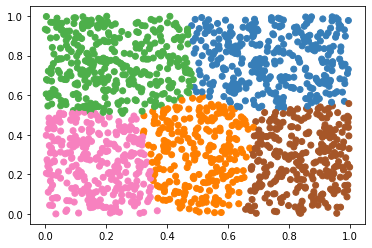

In [10]:
# When the data has no natural clusters,
# K-means might partion the data into equal size clusters.
# We will try K=5 and K=6 on same data.
make_clusters(no_structure,5)

iterations 26 ,cluster centers:
 [[0.30515572 0.14334549]
 [0.77673651 0.78946233]
 [0.13076876 0.42070493]
 [0.51963132 0.5035189 ]
 [0.22454585 0.81558428]
 [0.81630817 0.25459942]]
cluster assignments per point [1 3 5 ... 2 0 3]
SSE (optionally weighted) 43.231930886306486


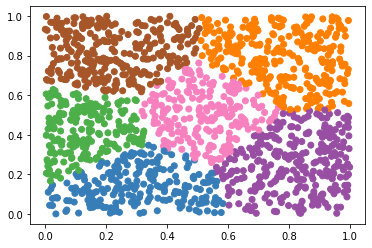

In [11]:
# Same as above with K=6.
make_clusters(no_structure,6)

### Bisecting Kmeans
This is another partition clustering algorithm.

This algorithm starts with one cluster
then iteratively cut one cluster into 2 (or into n). 
There are various strategies for choosing the next cluster to split.
This algorithm never generates empty clusters. 
You can't use this on K=2.

This is faster than Kmeans because it operates on data subsets,
so this is preferred on big data.
Compared to Kmeans with random initializers,
this is more likely to discover the data's natural hierarchy, and
less likely to generate a cluster of unrelated points.
However, this underperforms compared to 
Kmeans with Kmeans++ initializer.

SciKit-Learn:
* [BisectingKmeans](https://scikit-learn.org/dev/modules/generated/sklearn.cluster.BisectingKMeans.html)
is not yet released.
For now, you must install developer pre-release, ver 1.1. 
* This class has the same fields and methods as Kmeans. 
* You can set the bisection strategy to 
always choose the cluster with max(#points) or max(SSE). 
See [sklearn](https://scikit-learn.org/dev/auto_examples/cluster/plot_bisect_kmeans.html) to compare Kmeans with Bisecting Kmeans.

## Implement K-means from scratch.
For deeper understanding, we implement Kmeans from scratch.
To keep it simple, use only one feature i.e. one dimension.
The algorithm must slide the means left & right to find optimal.

Implementing our code, we compute and display SSE
to show that it reduces as the means approach 20 and 40. 
However, our topping criteria was delta mean, not SSE.

Testing our code, we found the initializers made a big difference.
The code often generated poor results when given bad initial values.

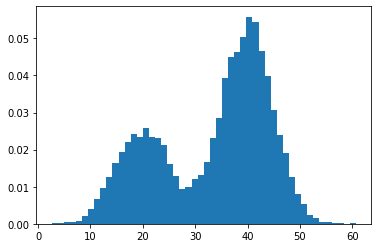

In [12]:
# Use data suggested by the Mastery site.
# Construct a bimodal from two Gaussian processes.
# Can K-means with K=2 reconstruct the 2 means?
from numpy import hstack
from numpy.random import normal
from matplotlib import pyplot
# normal ( mean, standard deviation, count )
def plot(X1,X2):
    X = hstack( (X1, X2) )  # horizontal stack i.e. concat
    pyplot.hist(X, bins=50, density=True)
    pyplot.show()
X1 = normal(loc=20, scale=5, size=3000) 
X2 = normal(loc=40, scale=5, size=6000)
plot(X1,X2)

In [13]:
def is_closer(point,this_mean,that_mean):
    return abs(point-this_mean) < abs(point-that_mean)
def sse(vector,mean):
    err=vector-mean
    se=np.square(err)
    sse=sum(se)
    return int(sse)
def assign_clusters(mean1,mean2,data):
    clust1=np.asarray([x for x in data if is_closer(x,mean1,mean2)])
    clust2=np.asarray([x for x in data if is_closer(x,mean2,mean1)])
    print('Cluster sizes:',len(clust1),len(clust2))
    sse1=sse(clust1,mean1)
    sse2=sse(clust2,mean2)
    print('Cluster SSE:',sse1,sse2)
    print('Cluster stdev:',np.sqrt(sse1)/len(clust1),np.sqrt(sse2)/len(clust2))
    return clust1,clust2
def recompute_means(clust1,clust2):
    mean1=np.mean(clust1)
    mean2=np.mean(clust2)
    print('Means:',mean1,mean2)
    return mean1,mean2
def iterative_2_means_delta(mean1,mean2,data,delta):
    """Iterate till the means change by less than delta."""
    # This code is for 1-dimensional means, so diff=mean1-mean2.
    # For matrix means, diff=element-wise subtract, norm=np.linalg.norm(diff)
    # i.e. sqrt of sum of squares of differences per dimension.
    # Assume both guesses are within the range of the data!
    clust1,clust2=assign_clusters(mean1,mean2,data)
    prev1=mean1
    prev2=mean2
    diff=delta+1
    while diff>delta:
        print()
        mean1,mean2=recompute_means(clust1,clust2)
        clust1,clust2=assign_clusters(mean1,mean2,data)
        # We tested with 2 norms and settled on L2.
        diff=max(abs(mean1-prev1),abs(mean2-prev2)) # L-inf norm
        diff=np.sqrt((mean1-prev1)**2+(mean2-prev2)**2) # L2 norm
        print('Diff:',diff,'Delta:',delta)
        prev1=mean1
        prev2=mean2
    return mean1,mean2

In [14]:
# Choose not-quite-random initializers, k=2.
guess1 = 40
guess2 = 41
X = hstack( (X1, X2) ) 
X = X.reshape((len(X), 1))
X = np.asarray(X)
print('Initial means:',guess1,guess2)
new1,new2=iterative_2_means_delta(guess1,guess2,X,0.01)

Initial means: 40 41
Cluster sizes: 6219 2781
Cluster SSE: 1350451 51358
Cluster stdev: 0.1868610817100005 0.08148976447907297

Means: 28.461799953867366 44.20398919710304
Cluster sizes: 4389 4611
Cluster SSE: 335005 84727
Cluster stdev: 0.1318742685043341 0.06312709327043362
Diff: 11.974790481663055 Delta: 0.01

Means: 24.271054874129607 41.94525439767727
Cluster sizes: 3478 5522
Cluster SSE: 154025 107072
Cluster stdev: 0.11284076741340084 0.05925725848958366
Diff: 4.760696085393735 Delta: 0.01

Means: 21.48432831231508 40.78463129301211
Cluster sizes: 3179 5821
Cluster SSE: 92509 121704
Cluster stdev: 0.09567565966149277 0.05993145573606564
Diff: 3.0187565190662875 Delta: 0.01

Means: 20.475345367254015 40.3442887730191
Cluster sizes: 3098 5902
Cluster SSE: 80662 127982
Cluster stdev: 0.09167545616005053 0.060614320527071316
Diff: 1.1008851522015781 Delta: 0.01

Means: 20.20582783277637 40.21307577843164
Cluster sizes: 3079 5921
Cluster SSE: 78499 129745
Cluster stdev: 0.09099601492